In [1]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:

df = pd.read_csv('raw_data/trafikkdata.csv', sep= r";|\|", engine='python')

Funksjon for å bare hente total trafikkmengde fra vegevesenets datasett

In [3]:
def clean_traffic_data(df):
    trafikkdata = df[['Dato', 'Fra tidspunkt', 'Til tidspunkt', 'Felt', 'Trafikkmengde']]
    trafikkdata = trafikkdata[trafikkdata['Felt'] == 'Totalt'].reset_index(drop=True) #bare interessert i total trafikkmengde
    trafikkdata = trafikkdata[trafikkdata['Dato'].notna()] #Dropper rader uten dato
    trafikkdata['Trafikkmengde'] = trafikkdata['Trafikkmengde'].replace('-', np.nan)
    trafikkdata['Tidspunkt'] = pd.to_datetime(trafikkdata['Dato'] + ' ' + trafikkdata['Fra tidspunkt'])
    trafikkdata = trafikkdata.drop(['Dato', 'Fra tidspunkt', 'Til tidspunkt', 'Felt'], axis = 1)
    trafikkdata.set_index('Tidspunkt', inplace = True)

    
    return trafikkdata

In [4]:
trafikkdata = clean_traffic_data(df)
trafikkdata

,Trafikkmengde
Tidspunkt,
2015-07-16 15:00:00,NaN
2015-07-16 16:00:00,101
2015-07-16 17:00:00,79
2015-07-16 18:00:00,56
2015-07-16 19:00:00,45
...,...
2023-07-01 19:00:00,NaN
2023-07-01 20:00:00,NaN
2023-07-01 21:00:00,NaN


In [5]:
#Slå sammen alle årene av værdata
cwd = os.getcwd()+'/raw_data'
filer = (os.listdir(cwd))
værdata = pd.DataFrame()
for i in filer:
    if i.startswith('Florida'):
        år = pd.read_csv('raw_data/'+i)
        værdata = pd.concat([værdata, år])

In [6]:
def clean_weather_data(df):
    værdata = df
    værdata = værdata.replace(9999.99, np.nan)
    værdata['Tidspunkt'] = pd.to_datetime(værdata['Dato'] + ' ' + værdata['Tid'])
    værdata = værdata.drop(['Dato', 'Tid', 'Relativ luftfuktighet', 'Lufttrykk'], axis = 1) #Tenker med en gang at relativ luftfuktighet, lufttrykk blir lite nyttige
    værdata.set_index('Tidspunkt', inplace = True)
    værdata = værdata.sort_values(['Tidspunkt'])
    værdata = værdata.resample('H').mean()
    værdata['Solskinstid'] = værdata['Solskinstid'] * 6 
    #siden solskinnstid er målt i minutter

    værdata.loc[værdata['Globalstraling'] < 0, 'Globalstraling'] = 0
    værdata.loc[værdata['Globalstraling'] > 1000, 'Globalstraling'] = np.nan
    #Globalstråling skal egentlig en positiv verdi eller 0
    #Over 1000 W/m2 på 1 time definerer jeg som ekstreme verdier, sett de til NaN slik at imputer kan håndtere

    return værdata



In [7]:
værdata = clean_weather_data(værdata)
værdata

,Globalstraling,Solskinstid,Lufttemperatur,Vindretning,Vindstyrke,Vindkast
Tidspunkt,,,,,,
2010-01-01 00:00:00,0.000000,0.0,-4.233333,150.333333,1.116667,NaN
2010-01-01 01:00:00,0.000000,0.0,-4.400000,144.000000,0.950000,NaN
2010-01-01 02:00:00,0.000000,0.0,-4.583333,143.000000,1.083333,NaN
2010-01-01 03:00:00,0.000000,0.0,-4.533333,130.333333,0.550000,NaN
2010-01-01 04:00:00,0.000000,0.0,-4.350000,144.000000,0.483333,NaN
...,...,...,...,...,...,...
2023-06-30 19:00:00,34.566667,0.0,13.666667,148.333333,2.800000,4.35
2023-06-30 20:00:00,7.966667,0.0,13.283333,141.166667,2.316667,3.90
2023-06-30 21:00:00,1.816667,0.0,13.466667,146.000000,3.250000,5.20


In [15]:
#lagre 2023 værdata som vi skal predikere etterpå
årets_vær = værdata.loc['2023']
årets_vær

,Globalstraling,Solskinstid,Lufttemperatur,Vindretning,Vindstyrke,Vindkast
Tidspunkt,,,,,,
2023-01-01 00:00:00,0.000000,0.0,0.716667,42.800000,1.283333,2.70
2023-01-01 01:00:00,0.000000,0.0,0.583333,54.666667,1.283333,3.10
2023-01-01 02:00:00,0.000000,0.0,-0.200000,38.666667,0.733333,2.05
2023-01-01 03:00:00,0.000000,0.0,-1.316667,135.000000,0.950000,2.25
2023-01-01 04:00:00,0.000000,0.0,0.833333,64.333333,3.266667,5.50
...,...,...,...,...,...,...
2023-06-30 19:00:00,34.566667,0.0,13.666667,148.333333,2.800000,4.35
2023-06-30 20:00:00,7.966667,0.0,13.283333,141.166667,2.316667,3.90
2023-06-30 21:00:00,1.816667,0.0,13.466667,146.000000,3.250000,5.20


In [9]:
#Slå sammen datasettene ved hjelp av datetimeindex. Lagre til fil slik vi kan lese den inn for å kjøre modellene
komplett_data = trafikkdata.merge(værdata, left_index=True, right_index=True).astype(float)
komplett_data = komplett_data[komplett_data["Trafikkmengde"].notna()] #Kolonner uten verdier for trafikkmengde blir irrelevante
komplett_data.to_csv('komplett_data.csv', date_format='%Y-%m-%d %H:%M')
komplett_data

,Trafikkmengde,Globalstraling,Solskinstid,Lufttemperatur,Vindretning,Vindstyrke,Vindkast
Tidspunkt,,,,,,,
2015-07-16 16:00:00,101.0,432.833333,48.7,13.733333,317.500000,4.333333,7.20
2015-07-16 17:00:00,79.0,378.400000,60.0,13.866667,318.166667,3.933333,6.55
2015-07-16 18:00:00,56.0,212.583333,60.0,13.216667,319.833333,4.233333,7.15
2015-07-16 19:00:00,45.0,79.750000,60.0,12.683333,323.500000,2.950000,5.45
2015-07-16 20:00:00,41.0,10.633333,36.0,12.066667,333.500000,2.483333,4.25
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.0,0.000000,0.0,1.766667,215.000000,1.283333,2.45
2022-12-31 20:00:00,0.0,0.000000,0.0,0.666667,258.666667,1.700000,3.15
2022-12-31 21:00:00,3.0,0.000000,0.0,0.483333,242.000000,0.833333,1.60


In [17]:
årets_trafikk = clean_traffic_data(pd.read_csv('raw_data/17510B2483952_hour_20230101T0000_20230701T0000.csv', sep= ';', encoding='latin1'))
ny_data = årets_trafikk.merge(årets_vær, left_index=True, right_index=True).astype(float)
ny_data = ny_data[ny_data["Trafikkmengde"].notna()]
ny_data.to_csv('2023.csv', date_format='%Y-%m-%d %H:%M')


In [10]:
test_kopi = komplett_data.copy().dropna()


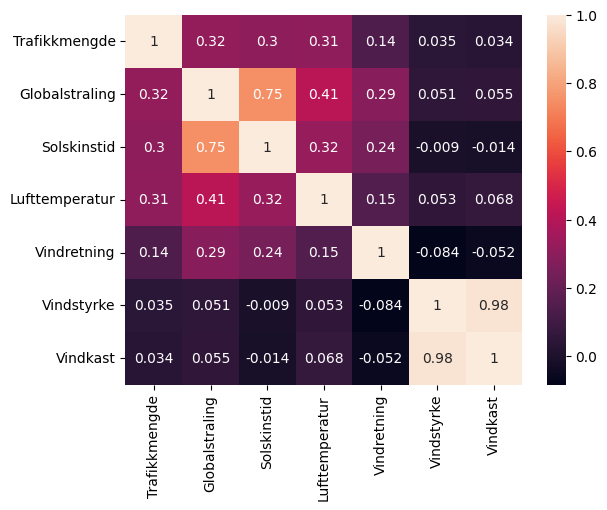

In [11]:
sn.heatmap(test_kopi.corr(), annot = True)
plt.show()

In [12]:
test_kopi['Lufttemperatur'] = test_kopi['Lufttemperatur'].apply(lambda x: int(x))
grader = test_kopi.groupby('Lufttemperatur')['Trafikkmengde'].mean()

fig = px.bar(grader, x = grader.index, y = grader, title= 'Gjennomsnittlig trafikkmengde for hver temperatur',
 labels = {'y': 'Trafikkmengde'})
fig.show()

Her har vi en grei visualisering av korrelasjon mellom temparatur og antall sykler. Denne grafen tar gjennomsnittet av trafikkmengden på en gitt temperatur i hele datasettet. Det var rundt 3000 forskjellige målte temperaturer, så jeg konverterte til int og hadde gjennomsnittet for hver hel grad i ceclius. Når jeg først prøvde å visualisere temperaturen, så brukte plotly express automatisk sum i stedet for mean. Da ble det rundt 10-12 grader som hadde mest trafikk, men det er jo fordi det er en mye vanligere temperatur i Norge, og det maler et feil bilde. Her ser vi tydelig at hvor varmere det er, jo flere folk sykler (ca). Det er litt svingninger men generelt kan vi si det. 

In [13]:
fig = px.scatter(test_kopi, x= 'Vindstyrke', y = 'Trafikkmengde', title= 'Trafikkmengde og vindstyrke')
fig.show()

 Når vindstyrke blir høy er det mer datapunkt med lav trafikkmengde, kan være nyttig å ha me i modellen, det samme gjelder for vindkast. 

In [14]:

timer = test_kopi.groupby(test_kopi.index.hour)['Trafikkmengde'].mean()
fig = px.bar(timer, x = timer.index, y = timer, title= 'Gjennomsnittlig trafikkmengde på hvert tidspunkt',
labels= {'y': 'Trafikkmengde'})
fig.update_xaxes(tickvals = list(range(24)))
fig.show()


Her ser vi at mye av syklingen er til og fra jobb og skole. 7-8 og 15-16, som alltid er rushtrafikken. Det er også naturligvis veldig få som sykler om natten. På kvelden og i arbeidstimene er det fortsatt en del sykler. 

In [15]:
soltid = pd.DataFrame(pd.cut(test_kopi['Solskinstid'], bins = [0,10,20,30,40,50,60]))
soltid['Trafikkmengde'] = test_kopi['Trafikkmengde']
intervall_soltid = pd.DataFrame(soltid.groupby('Solskinstid').mean()).reset_index()
intervall_soltid['Solskinstid'] = intervall_soltid['Solskinstid'].astype(str);




px.scatter(intervall_soltid, x = "Solskinstid", y = "Trafikkmengde")



Naturligvis mer sykling når det er sol. 

In [16]:
tid_kopi = test_kopi.copy()
tid_kopi['Dag'] = test_kopi.index.day_name() #lager en ny kolonne som sier hva dag det er
tid_kopi['Dato'] = test_kopi.index.date #lager en ny kolonne for datoen
dagtrafikk = tid_kopi.groupby(['Dag', 'Dato'])['Trafikkmengde'].sum().reset_index()
average_dag = dagtrafikk.groupby('Dag')['Trafikkmengde'].mean()

fig = px.bar(average_dag, x= average_dag.index, y = 'Trafikkmengde', title= 'Gjennomsnittlig trafikkmengde for hver dag')
fig.show()

Som vi og så fra "Gjennomsnittlig trafikkmengde for hvert tidspunkt" grafen, så er mange av syklene folk som skal til eller fra jobb. Og da minsker naturligvis trafikkmengden i helgen. Dette kan brukes. 

In [17]:
tid_kopi['Måned'] = test_kopi.index.month #lager en ny kolonne som sier hva måned det er
tid_kopi['År'] = test_kopi.index.year #lager kolonne som sier hva år det er
monthly = tid_kopi.groupby(['Måned', 'År'])['Trafikkmengde'].sum().reset_index()
average_monthly = monthly.groupby('Måned')['Trafikkmengde'].mean()


fig = px.bar(average_monthly, x= average_monthly.index, y = 'Trafikkmengde', title= 'Gjennomsnittlig trafikkmengde for hver måned')
fig.update_xaxes(tickvals = list(range(1, 13)))
fig.show()


Mindre sykling i juli, sannsynnligvis på grunn av fellesferien. Utenom juli, så ser vi at de varme månedene har mer sykkeltrafikk. 

In [18]:
yearly = tid_kopi.groupby('År')['Trafikkmengde'].sum().reset_index()

fig = px.bar(yearly, x = 'År', y= 'Trafikkmengde' ,title= 'Total trafikkmengde for hvert år')
#fig.update_xaxes(tickvals = list(range(1, 13)))
fig.show()

2015 har mindre trafikk ettersom dataen der startet i juli (dette er sum av trafikk for hvert år). Utenom det er det lite forskjell, det var faktisk ikke så mye mindre sykling i covid årene. 